# This is the official codebase for CS5079 Assessment 1 Group 5

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

if IS_COLAB or IS_KAGGLE:
    !apt update && apt install -y libpq-dev libsdl2-dev swig xorg-dev xvfb
    %pip install -U tf-agents pyvirtualdisplay
    %pip install -U gym>=0.21.0
    %pip install -U gym[box2d,atari,accept-rom-license]

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# To get smooth animations
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [29]:
# Imports
import tensorflow.compat.v1 as tf
import numpy as np
import pandas as pd

import random
import csv
import os

import gym

from collections import deque

In [3]:
env = gym.make("Asterix-v0")
env_ram = gym.make("Asterix-ram-v0")

### Description of environments

In [ ]:
print(f"Classic observation space: {env.observation_space}")
print(f"Classic action space: {env.action_space}")

print(f"RAM observation space: {env_ram.observation_space}")
print(f"RAM action space: {env_ram.action_space}")

In [5]:
# Code needed for when visualizing the game window in Colab

!pip install -U pyvirtualdisplay

try:
    import pyvirtualdisplay
    display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()
except ImportError:
    pass

In [22]:
# Plot the environment
def plot_environment(env, figsize=(5,4)):
    plt.figure(figsize=figsize)
    img = env.render(mode="rgb_array")
    plt.imshow(img)
    plt.axis("off")
    return img

# Preprocess the observation
def preprocess_obs(obs):
  img = obs[1:176:2, ::2]
  img = img.mean(axis=2)
  img = (img - 128) / 128 # Scale the pixels to [-1.0, 1.0]
  return img.reshape(88,80, 1)

# Blend between a number of observations
# Obtained from https://github.com/moduIo/Deep-Q-network/blob/master/DDQN.ipynb
def blend_images(images, blend):
  avg_image = np.expand_dims(np.zeros((88, 80, 1), np.float64), axis=0)
  for image in images:
    avg_image += image  

  if len(images) < blend:
    return avg_image / len(images)
  else:
    return avg_image / blend

# Obtain the indices of the important RAM cells
# This method has to be executed only once
def get_important_cells(ram1, ram2):
  cells = []
  for i in range(len(ram1)):
    if ram1[i] != ram2[i]:
      cells.append(i)

  return cells

Average reward: 310.0


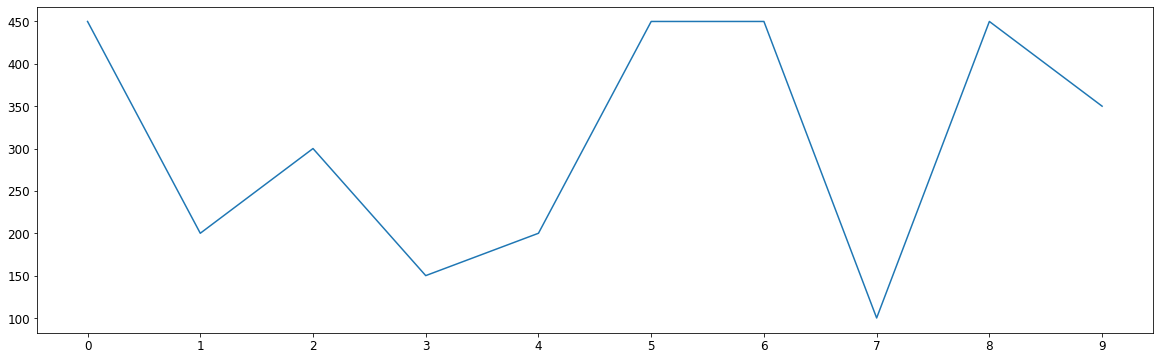

In [10]:
# Show how a random agent works -- code from the practical
class RandomAgent():
    def __init__(self, env):
        self.action_size = env.action_space.n
        
    def get_action(self, observation):
        return random.choice(range(self.action_size))
    
total_reward=0
ep_rewards = []
agent = RandomAgent(env)
numberOfEpisodes = 10
for steps in range(numberOfEpisodes):
    current_obs = env.reset()
    done = False
    while not done:
        action = agent.get_action(current_obs)
        next_obs, reward, done, info = env.step(action)
        total_reward += reward
        # env.render()
    ep_rewards.append(total_reward)
    total_reward = 0
print(f"Average reward: {sum(ep_rewards)/numberOfEpisodes}")

episodes = [x for x in range(len(ep_rewards))]
plt.rcParams['figure.figsize'] = (20,6)
plt.plot(episodes, ep_rewards)
plt.xticks(episodes)
plt.show()

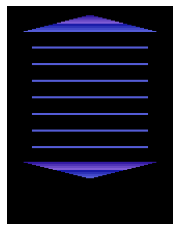

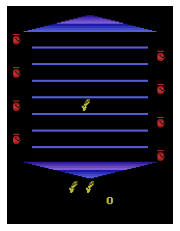

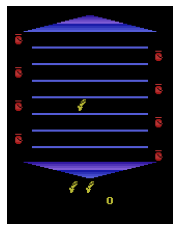

0.0
False
{'lives': 3}


In [21]:
# Show how the game works, how we visualize it and 
# the reward, done and info variables
obs = env.reset()
plot_environment(env)
plt.show()

obs, reward, done, info = env.step(8)

plot_environment(env)
plt.show()

obs, reward, done, info = env.step(5)

plot_environment(env)
plt.show()

print(reward)
print(done)
print(info)

### Task 1.4

In [24]:
def create_q_network(x_state, name):
  # we are not normalizing here as in the practical
  # because it's done in the preprocess_obs() method
  prev_layer = x_state
  initializer = tf.compat.v1.variance_scaling_initializer()
  with tf.compat.v1.variable_scope(name) as scope:
    # First Conv2D layer
    prev_layer = tf.layers.conv2d(prev_layer, filters=32, 
                                  kernel_size=8,strides=4,
                                  padding="SAME" ,
                                  activation=tf.nn.relu,
                                  kernel_initializer=initializer)
    # Second Conv2D layer
    prev_layer = tf.layers.conv2d(prev_layer, filters=64,
                                  kernel_size=4,strides=2,
                                  padding="SAME" ,
                                  activation=tf.nn.relu,
                                  kernel_initializer=initializer)
    # Third Conv2D layer
    prev_layer = tf.layers.conv2d(prev_layer, filters=64,
                                  kernel_size=3,strides=1,
                                  padding="SAME" , 
                                  activation=tf.nn.relu,
                                  kernel_initializer=initializer)
    # Flatten "layer"
    last_conv_layer_flat = tf.reshape(prev_layer, shape=[-1,64 * 11 * 10])
    hidden = tf.layers.dense(last_conv_layer_flat,512,
                              activation=tf.nn.relu,
                              kernel_initializer=initializer)
    hidden = tf.layers.dense(hidden,256,
                              activation=tf.nn.relu,
                              kernel_initializer=initializer)
    hidden = tf.layers.dense(hidden,64,
                              activation=tf.nn.relu,
                              kernel_initializer=initializer)
    outputs = tf.layers.dense(hidden, env.action_space.n,kernel_initializer=initializer)
  trainable_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=scope.name)
  trainable_vars_by_name = {var.name[len(scope.name):]: var for var in trainable_vars}
  return outputs, trainable_vars_by_name

In [25]:
# Agent memory from -- https://github.com/ageron/handson-ml/blob/master/16_reinforcement_learning.ipynb
class ReplayMemory:
  def __init__(self, maxlen):
    self.maxlen = maxlen
    self.buf = np.empty(shape=maxlen, dtype=np.object)
    self.index = 0
    self.length = 0
      
  def append(self, data):
    self.buf[self.index] = data
    self.length = min(self.length + 1, self.maxlen)
    self.index = (self.index + 1) % self.maxlen
  
  def sample(self, batch_size, with_replacement=True):
    if with_replacement:
        indices = np.random.randint(self.length, size=batch_size) # faster
    else:
        indices = np.random.permutation(self.length)[:batch_size]
    return self.buf[indices]

In [31]:
# Agent taken from the practical and expanded upon
class SmartAgent():
  def __init__(self, memlen=5000, epsilon_decay=1500000, cp_path='./my_dqn.ckpt'):
    tf.reset_default_graph()
    tf.disable_eager_execution()
    self.loss_val = np.inf
    self.action_size = env.action_space.n
    self.discount_rate = 0.95
    self.lr = 1e-2
    self.epsilon_decay = epsilon_decay
    self.cp_path = cp_path
    self.x_state = tf.placeholder(tf.float32, shape=[None, 88, 80, 1])
    self.memory = ReplayMemory(memlen)

    self.online_q_values, self.online_vars = create_q_network(self.x_state, name="q_net/online")
    self.target_q_values, self.target_vars = create_q_network(self.x_state, name="q_net/target")

    self.copy_ops = [target_var.assign(self.online_vars[var_name]) for var_name, target_var in self.target_vars.items()]
    self.copy_online_to_target=tf.group(*self.copy_ops)

    with tf.variable_scope("train"):
      self.X_action = tf.placeholder(tf.int32, shape=[None])
      self.y = tf.placeholder(tf.float32, shape=[None, 1])
      self.q_value = tf.reduce_sum(self.online_q_values * tf.one_hot(self.X_action, self.action_size),axis=1, keepdims=True)
      
      #If the error is between 0 and 1, 
      self.error = tf.abs(self.y - self.q_value)
      self.clipped_error = tf.clip_by_value(self.error, 0.0, 1.0)
      self.linear_error = 2 * (self.error - self.clipped_error)
      self.loss = tf.reduce_mean(tf.square(self.clipped_error) + self.linear_error)
      # self.loss = tf.reduce_mean(tf.losses.mean_squared_error(self.y, self.q_value))

      self.global_step = tf.Variable(0, trainable=False, name='global_step')
      self.optimizer = tf.train.AdamOptimizer(self.lr)
      # self.optimizer = tf.train.RMSPropOptimizer(self.lr)
      self.training_op = self.optimizer.minimize(self.loss, global_step=self.global_step)

    self.saver = tf.train.Saver()
    self.sess = tf.Session()
    if os.path.isfile(self.cp_path + ".index"):
      self.saver.restore(self.sess, self.cp_path)
    else:
      self.sess.run(tf.global_variables_initializer())
      self.sess.run(self.copy_online_to_target)

  def get_action(self,q_values, step):
        epsilon = max(0.1, 1 - (0.9/self.epsilon_decay) * step)
        # self.lr /= 2.0
        if np.random.rand() < epsilon:
            return np.random.randint(self.action_size) # random action
        else:
            return np.argmax(q_values) # optimal action

  def sample_memory(self, batch_size):
    cols = [[],[],[],[],[]]
    for memory in self.memory.sample(batch_size):
      for col, value in zip(cols, memory):
        col.append(value)
    cols = [np.array(col) for col in cols]
    return cols[0], cols[1], cols[2].reshape(-1, 1), cols[3], cols[4].reshape(-1, 1)

  def train(self, batch_size):
    # sample the memory
    state_val, action_val, rewards, next_state_val, cont = (self.sample_memory(batch_size))
    next_q_values = self.target_q_values.eval(feed_dict={self.x_state: next_state_val})
    max_next_q_values = np.max(next_q_values, axis=1, keepdims=True)
    y_val = rewards + cont * self.discount_rate * max_next_q_values

    _, self.loss_val = self.sess.run([self.training_op, self.loss], feed_dict={self.x_state: state_val, self.X_action: action_val, self.y: y_val})

In [32]:
agent = SmartAgent()
ep_rewards = [] # list to hold game score for each episode
total_reward = 0  # to track score per episode
n_steps = 5000 # maximum number of steps
training_start = 500  # at which step the training should begin
training_interval = 4 # run training at this interval 
copy_steps = 5000 # steps after which the agent will copy the DQN
save_steps = 1000 # steps after which the model will be saved
batch_size = 50 # batch size for the training
iteration = 0 # total number of iterations
episode = 0 # current episode (used for prints only)
done = True # env needs to be reset 

images_to_blend = deque(maxlen=4) # how many images from memory should be looked at

FILE_DIR = './rewards.csv'

# with open(FILE_DIR, 'a') as f:
#   writer = csv.writer(f)
#   writer.writerow(['reward'])
    

with agent.sess:
  while True:
    step = agent.global_step.eval()
    if step >= n_steps:
      break
    iteration += 1

    # print("\rIteration {}\tTraining step {}/{} ({:.1f})%\tLoss {:5f}\tEpisode {}".format(
    #         iteration, step, n_steps, step * 100 / n_steps, agent.loss_val, episode), end="")
    
    if done:
      # If we are done with the current episode,
      # save the game score to a csv file
      with open(FILE_DIR, 'a') as f:
        writer = csv.writer(f)
        writer.writerow([total_reward])
      episode += 1
      ep_rewards.append(total_reward)
      print(f"\tEpisode: {episode}\tStep: {step}\tReward: {total_reward}\tAvg Reward: {sum(ep_rewards)/len(ep_rewards)}")
      obs = env.reset()
      total_reward = 0
      state = preprocess_obs(obs)

    # Add the current state to the images to blend
    images_to_blend.append(state)

    # Obtain a blended image from the last 4 states
    blended_img = blend_images(images_to_blend, 4).reshape(88,80,1)

    # Generate Q values
    q_values = agent.online_q_values.eval(feed_dict={agent.x_state: [blended_img]})
    action = agent.get_action(q_values, step)

    next_obs, reward, done, info = env.step(action)
    next_state = preprocess_obs(next_obs) # preprocess the observation
    images_to_blend.append(next_state)  # and add it to the images to blend
    next_state = blend_images(images_to_blend, 4).reshape(88,80,1)

    # Add state to the memory of the agent
    agent.memory.append((state, action, reward, next_state, 1.0 - done))

    
    total_reward += reward
    state = next_state

    if iteration < training_start or iteration % training_interval != 0:
      continue  

    if step % copy_steps == 0:
      agent.copy_online_to_target.run()

    if step % save_steps == 0:
      agent.saver.save(agent.sess, agent.cp_path)

    agent.train(batch_size)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/convolutional.py:563: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future vers

	Episode: 1	Step: 0	Reward: 0	Avg Reward: 0.0
	Episode: 2	Step: 0	Reward: 250.0	Avg Reward: 125.0
	Episode: 3	Step: 45	Reward: 150.0	Avg Reward: 133.33333333333334
	Episode: 4	Step: 134	Reward: 250.0	Avg Reward: 162.5
	Episode: 5	Step: 256	Reward: 550.0	Avg Reward: 240.0
	Episode: 6	Step: 368	Reward: 400.0	Avg Reward: 266.6666666666667
	Episode: 7	Step: 486	Reward: 500.0	Avg Reward: 300.0
	Episode: 8	Step: 627	Reward: 600.0	Avg Reward: 337.5
	Episode: 9	Step: 731	Reward: 350.0	Avg Reward: 338.8888888888889
	Episode: 10	Step: 800	Reward: 100.0	Avg Reward: 315.0
	Episode: 11	Step: 873	Reward: 150.0	Avg Reward: 300.0
	Episode: 12	Step: 976	Reward: 350.0	Avg Reward: 304.1666666666667
	Episode: 13	Step: 1068	Reward: 250.0	Avg Reward: 300.0
	Episode: 14	Step: 1160	Reward: 350.0	Avg Reward: 303.57142857142856
	Episode: 15	Step: 1267	Reward: 450.0	Avg Reward: 313.3333333333333
	Episode: 16	Step: 1358	Reward: 350.0	Avg Reward: 315.625
	Episode: 17	Step: 1454	Reward: 250.0	Avg Reward: 311.764705

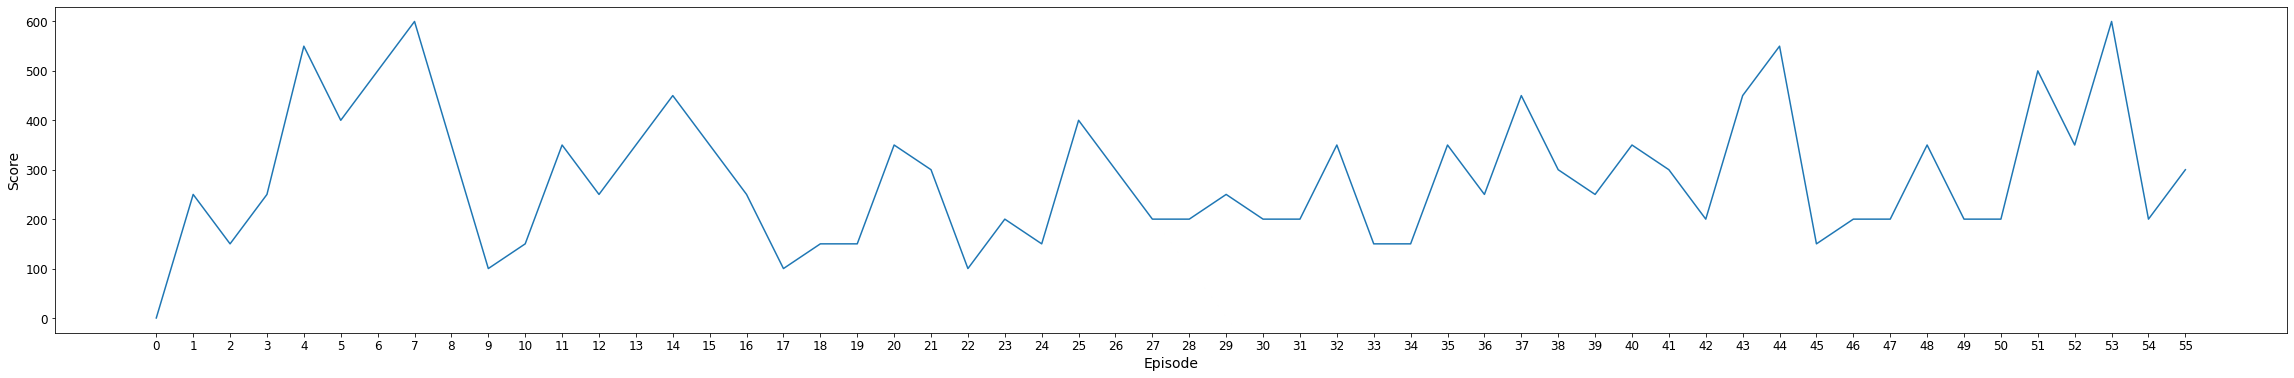

In [35]:
# Display the results (either from the csv or from the ep_rewards list)
episodes = [x for x in range(len(ep_rewards))]
plt.rcParams['figure.figsize'] = (40,6)
plt.plot(episodes, ep_rewards)
plt.xticks(episodes)
plt.xlabel('Episode')
plt.ylabel('Score')
plt.show()

In [36]:
# This cell can be used to load the model, let it play a game
# and visualize that game.

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
  fig = plt.figure()
  patch = plt.imshow(frames[0])
  plt.axis('off')
  anim = animation.FuncAnimation(
      fig, update_scene, fargs=(frames, patch),
      frames=len(frames), repeat=repeat, interval=interval)
  plt.close()
  return anim

frames = []
n_max_steps = 50000


agent = SmartAgent()

with agent.sess:
  agent.saver.restore(agent.sess, agent.cp_path)

  obs = env.reset()
  for step in range(n_max_steps):
    state = preprocess_obs(obs)

    q_values = agent.online_q_values.eval(feed_dict={agent.x_state: [state]})
    action = agent.get_action(q_values, step)

    obs, reward, done, info = env.step(action)

    img = env.render(mode="rgb_array")
    frames.append(img)

    if done:
      break

plot_animation(frames)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/convolutional.py:563: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future vers

INFO:tensorflow:Restoring parameters from ./my_dqn.ckpt
INFO:tensorflow:Restoring parameters from ./my_dqn.ckpt


#### Task 2

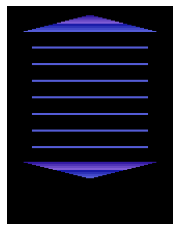

In [37]:
plot_environment(env_ram)
plt.show()

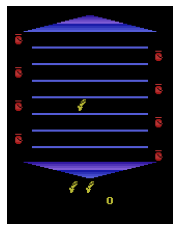

In [44]:
obs1 = env_ram.reset()
obs1, reward, done, info = env_ram.step(8)

plot_environment(env_ram)
plt.show()

#### This is the RAM-array that describes the environment. The next few cells will look at how that array changes and try to locate the important cells using the method created previously.

In [45]:
obs1

array([  0,   0, 100, 251,   1,   0,   0,   4,   1,   0,   0, 108, 108,
       108, 108, 108, 108, 108, 108,   1,   1,   1,   1,   1,   1,   1,
         1,  12,   0,   0,   0,   0,   0,   0,   0,   0,   0, 255,  24,
         4,  61,  68,   7, 142,   7, 142,   7, 142,   7, 142,   0,   0,
         1,   1,   0,   0,  25,  16,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,  50,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   3,   3,   0,   0,   7,   0, 188,  60,
       188, 129, 189,   0,   0,   0,   0,   0,   0,  81, 187,  81, 187,
        81, 187,  81, 187,  81, 187,   0, 187,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0, 216, 254, 107, 178], dtype=uint8)

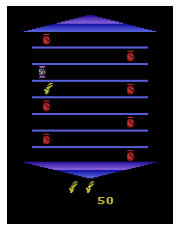

In [48]:
obs2, reward, done, info = env_ram.step(4)
obs2, reward, done, info = env_ram.step(6)
obs2, reward, done, info = env_ram.step(6)
obs2, reward, done, info = env_ram.step(6)
obs2, reward, done, info = env_ram.step(7)
obs2, reward, done, info = env_ram.step(8)

plot_environment(env_ram)
plt.show()

In [49]:
obs2

array([  0,   0, 100, 251,   1,   0,   0,  31,   1,   0,   0, 108, 108,
       108, 108, 108,  12, 108, 108,   1,   1,   1,   1,   1, 251,   1,
         1,  12,   0,   0,   0,   0,   0,   0,   0,   0,   0, 255,  24,
         3,  77,  36,  34, 115,  31, 115,  34, 115,  34, 115,   0,   0,
         1,   1,   0,   0,  25,  16,   0,   0,   0,   0,   0,   0,   0,
         0,   1,   0,   0,   0,  50,   0,   0,   0,   0,   3,   0,   0,
         0,   0,   0,   0,   0,   3,   3,   0,   0,  34,   0, 188,  60,
       188, 129, 189,   0,   0,  80,   0,   0,   0,  81, 187,  81, 187,
        81, 187,  81, 187,  40, 187,   0, 187,   0,   0,   0,   0,   0,
         0,  10,   0,   0,   0,   0,   0, 216, 254, 107, 178], dtype=uint8)

Experiments were performed and it was decided to use two particular states in order to obtain the important cells.

**State 1** - the initial state of the game.

**State 2** - a state at which the agent has collected 100 points and has died once.

These states are described by the following arrays.

In [53]:
x1 = [  0,   0, 100, 251,   1,   0,   0,   7,   1,   0,   0, 108, 108,
       108, 108, 108, 108, 108, 108,   1,   1,   1,   1,   1,   1,   1,
         1,  12,   0,   0,   0,   0,   0,   0,   0,   0,   0, 255,  24,
         5,  45,  70,  10, 139,  10, 139,  10, 139,  10, 139,   0,   0,
         1,   1,   0,   0,  25,  16,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,  50,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   3,   3,   0,   0,  10,   0, 188,  60,
       188, 129, 189,   0,   0,   0,   0,   0,   0,  81, 187,  81, 187,
        81, 187,  81, 187,  81, 187,   0, 187,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0, 216, 254, 107, 178]

x2 = [  0,   0, 100, 251,   1,   0,   0,  57,   1,   0,   0,  12, 108,
       108, 204, 108, 204, 108, 204,  40,   1,   1,   1,   1,   1,   1,
         1,  12,   1,  89,  96,  89,  96,  89,  96,  64,  34, 255,  24,
         7,  13,  36, 100,  57, 100,  57, 100,  57, 123,  82,   0,   0,
         1,   1,   0,   0,  25,  16,   0,   0,   0,   0,   0,   0,   0,
         0,   4,   0,   0,   0,  50,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   8,   0,   0,   2,   3,   0,   0,  50,   0, 188,  60,
       188, 129, 189,   0,   2,   0,   0,   0,   0,  81, 187,  81, 187,
        81, 187,  16, 187,   0, 187,   0, 187,   0, 126,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0, 216, 254, 107, 178]

important_cells = get_important_cells(x1, x2)

print(f"There are {len(important_cells)} important RAM cells.")

There are 34 important RAM cells.


In [61]:
# Create the Q Network for the RAM agent
def dense_network(X_state, name):
  initializer = tf.variance_scaling_initializer()
  with tf.variable_scope(name) as scope:
      prev_layer = tf.layers.dense(X_state, units=256,
                                    activation=tf.nn.relu,
                                    kernel_initializer=initializer)
      prev_layer = tf.layers.dense(prev_layer, units=128,
                                    activation=tf.nn.relu,
                                    kernel_initializer=initializer)
      hidden = tf.layers.dense(prev_layer,64,
                                activation=tf.nn.relu,
                                kernel_initializer=initializer)
      outputs = tf.layers.dense(hidden, env.action_space.n,kernel_initializer=initializer)
  trainable_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=scope.name)
  trainable_vars_by_name = {var.name[len(scope.name):]: var for var in trainable_vars}
  return outputs, trainable_vars_by_name

In [66]:
# Agent taken from the practical and expanded upon
class SmartAgentRAM():
  def __init__(self, memlen=5000, epsilon_decay=1500000, cp_path='./my_dqn_ram.ckpt'):
    tf.reset_default_graph()
    tf.disable_eager_execution()
    self.loss_val = np.inf
    self.action_size = env.action_space.n
    self.discount_rate = 0.95
    self.lr = 1e-2
    self.epsilon_decay = epsilon_decay
    self.cp_path = cp_path
    self.x_state = tf.placeholder(tf.float32, shape=[1, 34])
    self.memory = ReplayMemory(memlen)

    self.online_q_values, self.online_vars = dense_network(self.x_state, name="q_net_dense/online")
    self.target_q_values, self.target_vars = dense_network(self.x_state, name="q_net_dense/target")

    self.copy_ops = [target_var.assign(self.online_vars[var_name]) for var_name, target_var in self.target_vars.items()]
    self.copy_online_to_target=tf.group(*self.copy_ops)

    with tf.variable_scope("train_dense"):
      self.X_action = tf.placeholder(tf.int32, shape=[None])
      self.y = tf.placeholder(tf.float32, shape=[None, 1])
      self.q_value = tf.reduce_sum(self.online_q_values * tf.one_hot(self.X_action, self.action_size),axis=1, keepdims=True)
      
      #If the error is between 0 and 1, 
      self.error = tf.abs(self.y - self.q_value)
      self.clipped_error = tf.clip_by_value(self.error, 0.0, 1.0)
      self.linear_error = 2 * (self.error - self.clipped_error)
      self.loss = tf.reduce_mean(tf.square(self.clipped_error) + self.linear_error)
      # self.loss = tf.reduce_mean(tf.losses.mean_squared_error(self.y, self.q_value))

      self.global_step = tf.Variable(0, trainable=False, name='global_step')
      self.optimizer = tf.train.AdamOptimizer(self.lr)
      # self.optimizer = tf.train.RMSPropOptimizer(self.lr)
      self.training_op = self.optimizer.minimize(self.loss, global_step=self.global_step)

    self.saver = tf.train.Saver()
    self.sess = tf.Session()
    if os.path.isfile(self.cp_path + ".index"):
      self.saver.restore(self.sess, self.cp_path)
    else:
      self.sess.run(tf.global_variables_initializer())
      self.sess.run(self.copy_online_to_target)

  def get_action(self,q_values, step):
        epsilon = max(0.1, 1 - (0.9/self.epsilon_decay) * step)
        # self.lr /= 2.0
        if np.random.rand() < epsilon:
            return np.random.randint(self.action_size) # random action
        else:
            return np.argmax(q_values) # optimal action

  def sample_memory(self, batch_size):
    cols = [[],[],[],[],[]]
    for memory in self.memory.sample(batch_size):
      for col, value in zip(cols, memory):
        col.append(value)
    cols = [np.array(col) for col in cols]
    return cols[0], cols[1], cols[2].reshape(-1, 1), cols[3], cols[4].reshape(-1, 1)

  def train(self, batch_size):
    # sample the memory
    state_val, action_val, rewards, next_state_val, cont = (self.sample_memory(batch_size))
    next_q_values = self.target_q_values.eval(feed_dict={self.x_state: next_state_val})
    max_next_q_values = np.max(next_q_values, axis=1, keepdims=True)
    y_val = rewards + cont * self.discount_rate * max_next_q_values

    _, self.loss_val = self.sess.run([self.training_op, self.loss], feed_dict={self.x_state: state_val, self.X_action: action_val, self.y: y_val})

In [68]:
agent = SmartAgentRAM()
ep_rewards = [] # list to hold game score for each episode
total_reward = 0  # to track score per episode
n_steps = 5000 # maximum number of steps
training_start = 500  # at which step the training should begin
training_interval = 4 # run training at this interval 
copy_steps = 5000 # steps after which the agent will copy the DQN
save_steps = 1000 # steps after which the model will be saved

# NOTE that batch_size must be 1 because the algorithm
# is not programmed to take in a batch of RAM states
# This is a limitation of the implementation
batch_size = 1 # batch size for the training


iteration = 0 # total number of iterations
episode = 0 # current episode (used for prints only)
done = True # env needs to be reset 

FILE_DIR = './rewards_ram.csv'

# with open(FILE_DIR, 'a') as f:
#   writer = csv.writer(f)
#   writer.writerow(['reward'])
    

with agent.sess:
  while True:
    step = agent.global_step.eval()
    if step >= n_steps:
      break
    iteration += 1

    # print("\rIteration {}\tTraining step {}/{} ({:.1f})%\tLoss {:5f}\tEpisode {}".format(
    #         iteration, step, n_steps, step * 100 / n_steps, agent.loss_val, episode), end="")
    
    if done:
      # If we are done with the current episode,
      # save the game score to a csv file
      with open(FILE_DIR, 'a') as f:
        writer = csv.writer(f)
        writer.writerow([total_reward])
      episode += 1
      ep_rewards.append(total_reward)
      print(f"\tEpisode: {episode}\tStep: {step}\tReward: {total_reward}\tAvg Reward: {sum(ep_rewards)/len(ep_rewards)}")
      obs = env_ram.reset()
      total_reward = 0
      state = obs[important_cells]

    # Generate Q values
    q_values = agent.online_q_values.eval(feed_dict={agent.x_state: [state]})
    action = agent.get_action(q_values, step)

    next_obs, reward, done, info = env_ram.step(action)
    next_state = next_obs[important_cells]

    # Add state to the memory of the agent
    agent.memory.append((state, action, reward, next_state, 1.0 - done))

    total_reward += reward
    state = next_state

    if iteration < training_start or iteration % training_interval != 0:
      continue  

    if step % copy_steps == 0:
      agent.copy_online_to_target.run()

    if step % save_steps == 0:
      agent.saver.save(agent.sess, agent.cp_path)

    agent.train(batch_size)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  import sys
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: `tf.layers.dense` is de

INFO:tensorflow:Restoring parameters from ./my_dqn_ram.ckpt
	Episode: 1	Step: 0	Reward: 0	Avg Reward: 0.0
	Episode: 2	Step: 0	Reward: 250.0	Avg Reward: 125.0
	Episode: 3	Step: 107	Reward: 400.0	Avg Reward: 216.66666666666666
	Episode: 4	Step: 177	Reward: 200.0	Avg Reward: 212.5
	Episode: 5	Step: 243	Reward: 100.0	Avg Reward: 190.0
	Episode: 6	Step: 343	Reward: 200.0	Avg Reward: 191.66666666666666
	Episode: 7	Step: 418	Reward: 150.0	Avg Reward: 185.71428571428572
	Episode: 8	Step: 480	Reward: 150.0	Avg Reward: 181.25
	Episode: 9	Step: 573	Reward: 250.0	Avg Reward: 188.88888888888889
	Episode: 10	Step: 653	Reward: 250.0	Avg Reward: 195.0
	Episode: 11	Step: 749	Reward: 250.0	Avg Reward: 200.0
	Episode: 12	Step: 821	Reward: 300.0	Avg Reward: 208.33333333333334
	Episode: 13	Step: 894	Reward: 150.0	Avg Reward: 203.84615384615384
	Episode: 14	Step: 968	Reward: 200.0	Avg Reward: 203.57142857142858
	Episode: 15	Step: 1036	Reward: 150.0	Avg Reward: 200.0
	Episode: 16	Step: 1147	Reward: 400.0	Avg

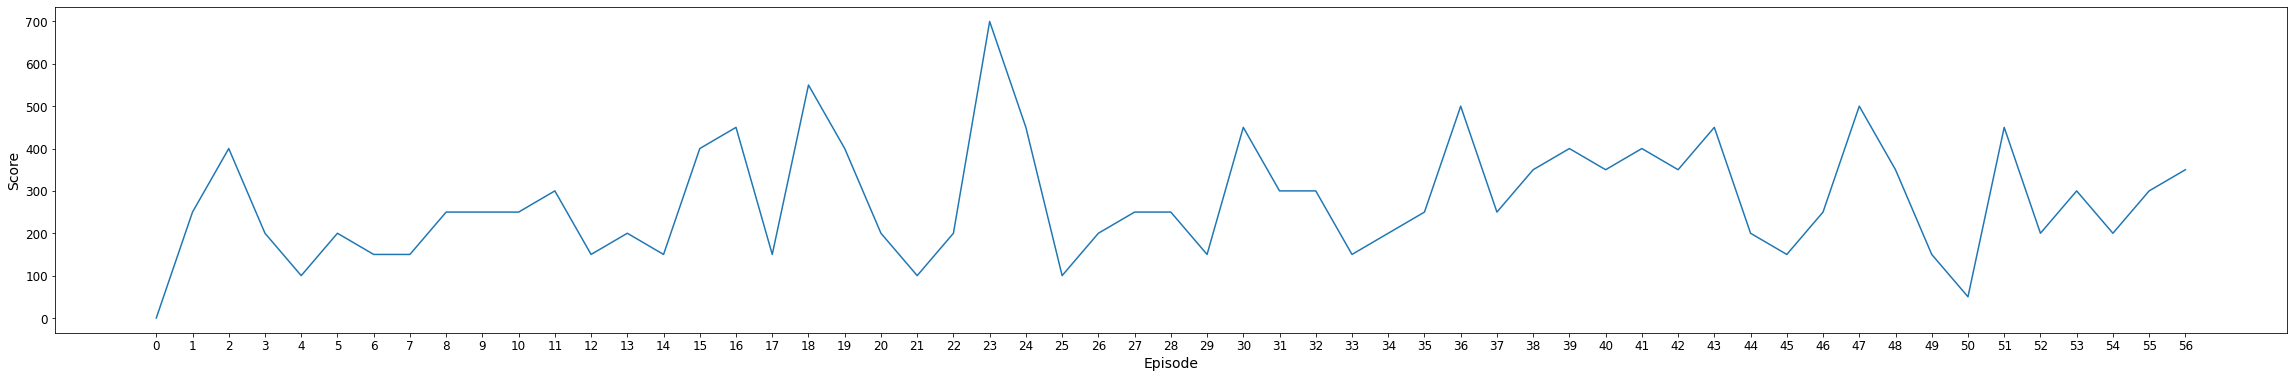

In [70]:
episodes = [x for x in range(len(ep_rewards))]
plt.rcParams['figure.figsize'] = (40,6)
plt.plot(episodes, ep_rewards)
plt.xticks(episodes)
plt.xlabel('Episode')
plt.ylabel('Score')
plt.show()

Comparison

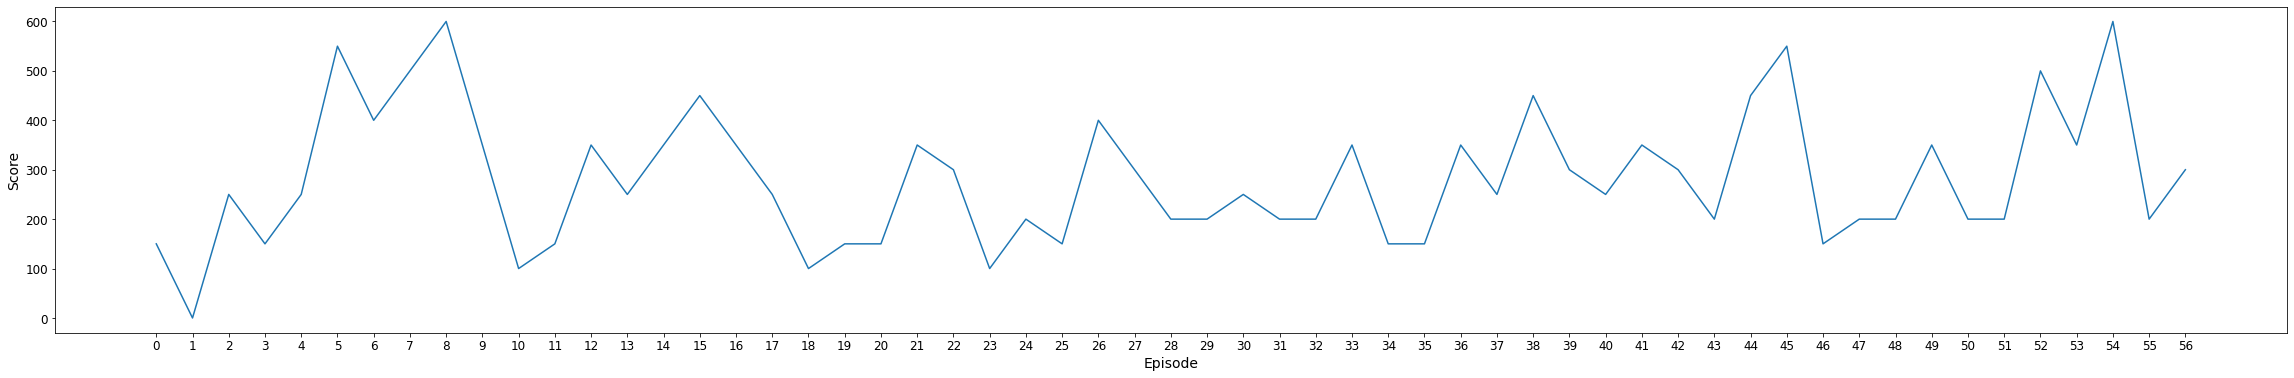

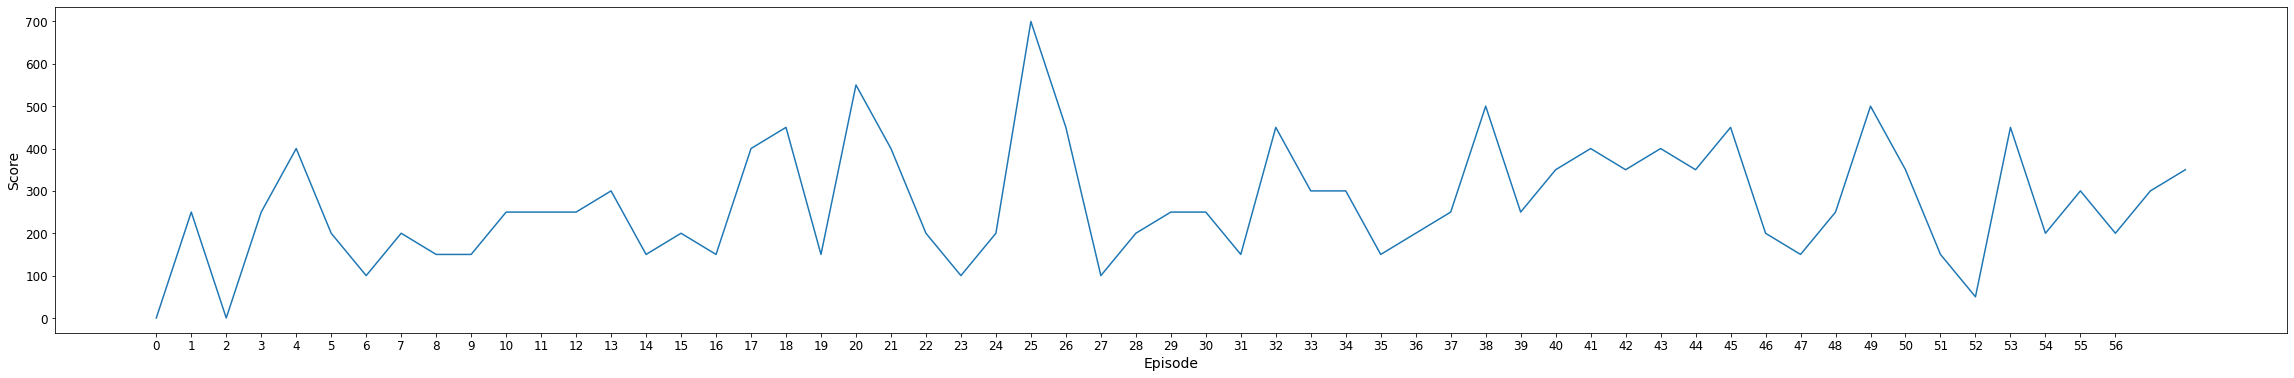

In [74]:
df = pd.read_csv('rewards.csv')
df_ram = pd.read_csv('rewards_ram.csv')

plt.rcParams['figure.figsize'] = (40,6)
plt.plot([x for x in range(len(df['0']))], df['0'])
plt.xticks(episodes)
plt.xlabel('Episode')
plt.ylabel('Score')
plt.show()

plt.rcParams['figure.figsize'] = (40,6)
plt.plot([x for x in range(len(df_ram['0']))], df_ram['0'])
plt.xticks(episodes)
plt.xlabel('Episode')
plt.ylabel('Score')
plt.show()
